# Problem Statement

As data scientists, you are assigned with a task to categorize the messages in the dataset "SPAMdata" as spam or ham.
The project's primary objective is to find spam messages.

Approach: Data analysis came first, then feature extraction, data preparation, and data modeling.

# Importing libraries

In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import string
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
from spacy.lang.en import English
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
import sklearn.model_selection
from sklearn import decomposition

# Loading Dataset

In [2]:
df = pd.read_csv("../../datasets/SPAMData.csv")
df.head()

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


There are two key columns in the dataset: "the spam message" and "spam, ham." The label spam denotes that the communication is spam, whereas the label ham denotes that it is not.

In [3]:
#Calculating the length of the message
df["length"]= df["Message"].apply(len)
df.head()

,Category,Message,length
0,ham,"Go until jurong point, crazy.. Available only ...",111
1,ham,Ok lar... Joking wif u oni...,29
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155
3,ham,U dun say so early hor... U c already then say...,49
4,ham,"Nah I don't think he goes to usf, he lives aro...",61


In [4]:
#Finding out the maximum length of a message
df["length"].max()

910

We discovered that a message's maximum length is "910."

In [5]:
#Check for null values
df.isnull().sum()

Category    0
Message     0
length      0
dtype: int64

There are no nullvalues in this dataset.

**Visualizing the Category feature**

In [6]:
#Count of spam and ham messages
df["Category"].value_counts()

ham     4825
spam     747
Name: Category, dtype: int64

<AxesSubplot:xlabel='Category', ylabel='count'>

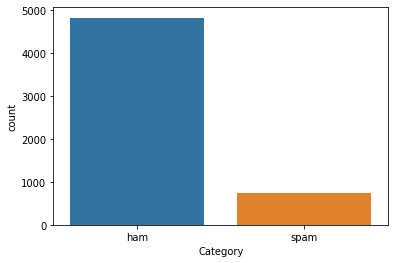

In [7]:
sns.countplot(x= df.Category)

It's evident from the graph above that our dataset contains more non-spam messages than spam ones. There are 4825 ham messages and 747 spam messages.

# Balance the dataset

The dataset is severely skewed, and training a machine learning model with unbalanced data is not a smart idea.
As a result, we'll now balance the data.

In [8]:
ham = df[df["Category"]=="ham"]
ham.head()

,Category,Message,length
0,ham,"Go until jurong point, crazy.. Available only ...",111
1,ham,Ok lar... Joking wif u oni...,29
3,ham,U dun say so early hor... U c already then say...,49
4,ham,"Nah I don't think he goes to usf, he lives aro...",61
6,ham,Even my brother is not like to speak with me. ...,77


In [9]:
spam = df[df["Category"]=="spam"]
spam.head()

,Category,Message,length
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155
5,spam,FreeMsg Hey there darling it's been 3 week's n...,147
8,spam,WINNER!! As a valued network customer you have...,157
9,spam,Had your mobile 11 months or more? U R entitle...,154
11,spam,"SIX chances to win CASH! From 100 to 20,000 po...",136


In [10]:
#print the shape of spam and ham
spam.shape, ham.shape

((747, 3), (4825, 3))

There are 747 messages in our spam dataset and 4825 messages in our ham dataset. We need to choose 747 messages from the ham dataset to balance the data.

In [11]:
ham = ham.sample(spam.shape[0])
ham.shape, spam.shape

((747, 3), (747, 3))

We've now achieved perfect data balance.

In [12]:
#Append the dataset to df
df = ham.append(spam, ignore_index=True)
df.head()

,Category,Message,length
0,ham,Oh k.k..where did you take test?,32
1,ham,I dont know what to do to come out of this so ...,94
2,ham,Gd luck 4 ur exams :-),22
3,ham,"Very hurting n meaningful lines ever: ""I compr...",147
4,ham,Neshanth..tel me who r u?,25


# Most frequently used words in spam messages

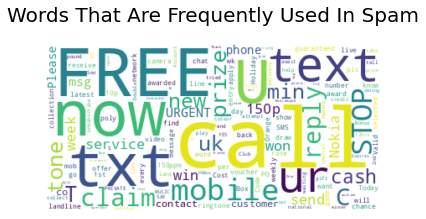

In [13]:
word_text = df[df.Category == 'spam']

text = " ".join(text for text in word_text["Message"])

word_cloud = WordCloud(background_color = "white", max_words=150, collocations = False).generate(text)

plt.imshow(word_cloud, interpolation='bilinear')
plt.title("Words That Are Frequently Used In Spam", fontsize=20, y=1.1)
plt.axis("off");

Spam Text contains words like "call", "free", "claim", "now etc"

# Most Frequently used words in ham messages

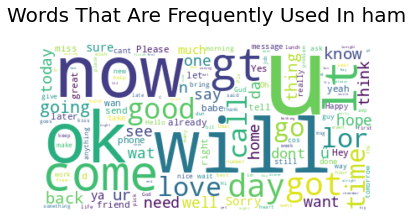

In [14]:
nonspam_text= df[df.Category == "ham"]

hamtexts= " ".join(text for text in nonspam_text["Message"])

nonspam_cloud = WordCloud(background_color = 'white', max_words=150, collocations = False).generate(hamtexts)

plt.imshow(nonspam_cloud, interpolation='bilinear')
plt.title("Words That Are Frequently Used In ham", fontsize=20, y=1.1)
plt.axis("off");

Ham text contains words like "now", "know", "u", "wil" etc

# DATA PREPROCESSING

 **Tokenizer**

Let's create a custom tokenizer function with spaCy. This feature will be used to automatically eliminate non-essential material from each review, such as stopwords and punctuation.

In [15]:
#Create list of punctuation marks
punct = string.punctuation

#Create list of stopwords
nlp = spacy.load("en_core_web_sm")
stop_words = spacy.lang.en.stop_words.STOP_WORDS

parser = English()

def tokenizer(sentence):
    #create an object
    token = parser(sentence)
    #Each string is lemmatized and converted to lower case.
    token = [ word.lemma_.lower().strip() if word.lemma_ != "-PRON-" else word.lower_ for word in token ]
    #Deleting stopwords
    token = [ word for word in token if word not in stop_words and word not in punct ]
    return token

To tidy up our text data even more, we'll need to make a custom transformer that removes the first and last spaces and converts the text to lower case.

In [16]:
from sklearn.base import TransformerMixin
class token(TransformerMixin):
    def transform(self, x, **transform_params):
        #Purify the text
        return [purify_token(term) for term in x]
    
    def fit(self, x, y=None, **fit_params):
        return self

    def get_params(self, deep=True):
        return {}
#Define a function to purify the content  
def purify_token(term):
    
    #Converting text to lowercase and removing spaces
    return term.strip().lower()

 **Words or word groups that have had letters removed and been replaced with an apostrophe are said to be contracted**

In [17]:
#Defining contactions
contractions = {
"aight": "alright",
"ain't": "am not",
"amn't": "am not",
"aren't": "are not",
"can't": "can not",
"cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"daren't": "dare not",
"daresn't": "dare not",
"dasn't": "dare not",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"d'ye": "do you",
"e'er": "ever",
"everybody's": "everybody is",
"everyone's": "everyone is",
"finna": "fixing to",
"g'day": "good day",
"gimme": "give me",
"giv'n": "given",
"gonna": "going to",
"gon't": "go not",
"gotta": "got to",
"hadn't": "had not",
"had've": "had have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he would",
"he'dn't've'd": "he would not have had",
"he'll": "he will",
"he's": "he is",
"he've": "he have",
"how'd": "how did",
"howdy": "how do you do",
"how'll": "how will",
"how're": "how are",
"I'll": "I will",
"I'm": "I am",
"I'm'a": "I am about to",
"I'm'o": "I am going to",
"innit": "is it not",
"I've": "I have",
"isn't": "is not",
"it'd": "it would",
"it'll": "it will",
"it's": "it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"may've": "may have",
"methinks": "me thinks",
"mightn't": "might not",
"might've": "might have",
"mustn't": "must not",
"mustn't've": "must not have",
"must've": "must have",
"needn't": "need not",
"ne'er": "never",
"o'clock": "of the clock",
"o'er": "over",
"ol'": "old",
"oughtn't": "ought not",
"'s": "is, has, does, or us",
"shalln't": "shall not",
"shan't": "shall not",
"she'd": "she had",
"she'll": "she will",
"she's": "she is",
"should've": "should have",
"shouldn't": "should not",
"shouldn't've": "should not have",
"somebody's": "somebody is",
"someone's": "someone is",
"something's": "something is",
"so're": "so are",
"that'll": "that will",
"that're": "that are",
"that's": "that is",
"that'd": "that would",
"there'd": "there had",
"there'll": "there will",
"there're": "there are",
"there's": "there is",
"these're": "these are",
"these've": "these have",
"they'd": "they had",
"they'll": "they will",
"they're": "they are",
"they've": "they have",
"this's": "this is",
"those're": "those are",
"those've": "those have",
"'tis": "it is",
"to've": "to have",
"'twas": "it was",
"wanna": "want to",
"wasn't": "was not",
"we'd": "we had",
"we'll": "we will",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'd": "what did",
"what'll": "what will",
"what're": "what are",
"what's": "what is",
"what've": "what have",
"when's": "when is",
"where'd": "where did",
"where'll": "where will",
"where're": "where are",
"where's": "where is",
"where's": "where does",
"where've": "where have",
"which'd": "which would",
"which'll": "which will",
"which're": "which are",
"which's": "which is",
"which've": "which have",
"who'd": "who would",
"who'd've": "who would have",
"who'll": "who will",
"who're": "who are",
"who's": "who does",
"who've": "who have",
"why'd": "why did",
"why're": "why are",
"why's": "why does",
"won't": "will not",
"would've": "would have",
"wouldn't": "would not",
"wouldn't've": "would not have",
"y'all": "you all",
"y'all'd've": "you all would have",
"y'all'dn't've'd": "you all would not have had",
"y'all're": "you all are",
"you'd": "you would",
"you'll": "you will",
"you're": "you are",
"you've": "you have",
" u ": "you",
" ur ": "your",
" n ": "and"
}

In [18]:
def decontracted(a):
    if type(a) is str:
        for key in contractions:
            value = contractions[key]
            a = a.replace(key,value)
        return a
    else:
        return a

In [19]:
df["Message"] = df["Message"].apply(lambda a: decontracted(a))

Replaced words which are shortened by dropping letters with apostrophe

# Feature Extraction

**Bag of Words**

Let's categorize the text into two groups: spam and ham labels. Bag of Words (BoW) transforms text into a matrix of word occurrences inside a document. It focuses on whether certain terms appeared in the document or not, and it generates a matrix known as a BoW matrix or a document term matrix.

In [20]:
BoW = CountVectorizer(tokenizer = tokenizer, ngram_range=(1,1))

**TF-IDF method of normalizing our Bag of Words (BoW) by comparing the frequency of each word to the frequency of the document**

In [21]:
tfidf = TfidfVectorizer(tokenizer = tokenizer)

# Converting to numeric value

In [22]:
x = df["Message"]
df["new_category"]= df["Category"].apply(lambda x: 1 if x=="spam" else 0)
y = df["new_category"]

In [23]:
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(x).toarray()

# Splitting the dataset into train and test set

In [24]:
x_train,x_test, y_train, y_test= train_test_split(X,y,test_size=0.3, random_state=0, 
                                                  shuffle=True, stratify= y)

# DECISION TREE CLASSIFIER

In [25]:
#Create the object model
model1= DecisionTreeClassifier()
#Fit model to data
model1.fit(x_train, y_train)
#Generate Predictions
model1_predict=model1.predict(x_train)
#Generate accuracy
accuracy = accuracy_score(y_train, model1_predict)
print("Accuracy Score:", accuracy)
#Genrate classification report

print(classification_report(y_train, model1_predict))

Accuracy Score: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       522
           1       1.00      1.00      1.00       523

    accuracy                           1.00      1045
   macro avg       1.00      1.00      1.00      1045
weighted avg       1.00      1.00      1.00      1045



# Random Forest model

In [26]:
#Create the object model
model= RandomForestClassifier()
#Fit model to data
model.fit(x_train, y_train)
#Generate Predictions
model_predict = model.predict(x_train)
#Generate accuracy
accuracy = accuracy_score(y_train, model_predict)
print("Accuracy Score:", accuracy)
#Generate classification report
print(classification_report(y_train, model_predict))

Accuracy Score: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       522
           1       1.00      1.00      1.00       523

    accuracy                           1.00      1045
   macro avg       1.00      1.00      1.00      1045
weighted avg       1.00      1.00      1.00      1045



# Decision Tree with Hyperparameter tuning

In [ ]:

#define parameters
parameters_grid = {"max_depth":range(1, model1.tree_.max_depth+1, 2),
                   "max_features": range(1, len(model1.feature_importances_)+1)}

#define grid search for training model
model5 = GridSearchCV(DecisionTreeClassifier(random_state=42),
                      param_grid=parameters_grid,
                      scoring='accuracy',
                      n_jobs=-1)

model5.fit(x_train, y_train)

#generate accuracy 
print("Accuracy of best Decision Tree classifier= {:.2f}".format(model5.best_score_))
print("Best found hyperparameters of Decision Tree classifier= {}"
      .format(model5.best_params_))

# Testing the best model

In [29]:
Y_predicted = model.predict(x_test)
accuracy = sklearn.metrics.accuracy_score(y_test, Y_predicted)
accuracy
#Generate classification report
print(classification_report(y_test, Y_predicted))

              precision    recall  f1-score   support

           0       0.90      1.00      0.95       225
           1       1.00      0.89      0.94       224

    accuracy                           0.94       449
   macro avg       0.95      0.94      0.94       449
weighted avg       0.95      0.94      0.94       449



# Conclusion

For spam text classification, we achieved a 93% accuracy rate. Our program correctly predicted spam messages 99 percent of the time and non-spam messages 89 percent of the time. The text was divided into two categories: spam and ham labels. Bag of Words (BoW) converts text into a matrix of word occurrences inside a document, which is then normalized using the Tf-IDF approach. Finally, using the usual random-forest classification method, a model with 93 percent accuracy was obtained.

Dataset link: https://www.kaggle.com/datasets/team-ai/spam-text-message-classification

**References**

Kaggele: https://www.kaggle.com/datasets/team-ai/spam-text-message-classification

 [Pietro, Mauro, 2020] Textclassification with NLP
 
kaggel: https://www.kaggle.com/code/mrvendetta7/spamham-classification-99-accuracy-with-fastai
